# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). The data is sampled for you to something more manageable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, add comments and conclusions about your findings and describe anything you want to analyze in the future.

## Challenge Objectives
Successfully complete all these objectives to earn full credit. 

**Successful completion is defined as passing all the unit tests in each objective.**  

Each unit test that you pass is 1 point. 

There are 5 total possible points in this sprint challenge. 


There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on Yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

____

# Before you submit your notebook you must first

1) Restart your notebook's Kernel

2) Run all cells sequentially, from top to bottom, so that cell numbers are sequential numbers (i.e. 1,2,3,4,5...)
- Easiest way to do this is to click on the **Cell** tab at the top of your notebook and select **Run All** from the drop down menu. 

3) **Comment out the cell that generates a pyLDAvis visual in objective 4 (see instructions in that section).** 
____

In [ ]:
# !pip install pyLDAvis==3.3.1

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 43.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


### Part 0: Import Necessary Packages
For this section, you will need to import:
- `spacy` 
- `Pandas`
- `Seaborn`
- `Matplotlib`
- `NearestNeighbors`
- `Pipeline` 
- `TfidfVectorizer`
- `KneighborsClassifier`
- `GridSearchCV`
- `corpora`
- `LdaModel`
- `gensim`
- `re`

> **Note: This assignment is optimized to work with these specific packages. You can use import different packages, but note that this may affect how CodeGrade works, and may cause CodeGrade to fail.**

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

# import pyLDAvis
# import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors


from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is saf

In [ ]:
# Visible Testing
assert pd.__package__ == 'pandas'




### Part 0: Import Data

In [ ]:


# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/bloominstituteoftechnology/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import data into a DataFrame named df
df = pd.read_json(data_url, lines=True)

In [ ]:
# Visible Testing
assert isinstance(df, pd.DataFrame), 'df is not a DataFrame. Did you import the data into df?'
assert df.shape[0] == 10000, 'DataFrame df has the wrong number of rows.'

In [ ]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [ ]:
def clean_data(text):
    """
    Accepts a single text document and performs several regex substitutions in order to clean the document. 
    
    Parameters
    ----------
    text: string or object 
    
    Returns
    -------
    text: string or object
    """
    
    # order of operations - apply the expression from top to bottom
    date_regex = r"\d+/\d+/\d+"
    punct_regex = r"[^a-zA-Z\s]" # any non-alphanumeric chars
    special_chars_regex = r"[\$\%\&\@+]" 
    numerical_regex =  r"\d+"  # match one or more digits
    
    # Replace any strings matching the above regex patterns with blank strings
    # (effectively removing them from the text)
    text = re.sub(date_regex, "", text)
    text = re.sub(punct_regex, "", text)
    text = re.sub(special_chars_regex, "", text)
    text = re.sub(numerical_regex, "", text)
    return text.lower()

In [ ]:
df['text'] = df['text'].astype(str)

In [ ]:
df['text'] = df['text'].apply(clean_data)

df['text'][0]

'beware fake fake fakewe also own a small business in los alamitos ca and received what looked like a legitimate bill for  with an account number and all  i called the phone number listed    the wait time on hold said  minutes and to leave a message  i could not get a live person on the phone no matter what number i selected  i left a very firm message that i would be contacting the bbb and my attorney regarding their company trying to scam businesses this has to be illegal'

In [ ]:
df.dtypes

business_id            object
cool                    int64
date           datetime64[ns]
funny                   int64
review_id              object
stars                   int64
text                   object
useful                  int64
user_id                object
dtype: object

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- Accept one document at a time
- Return a list of tokens

You are free to use any method you have learned this week.

In [ ]:
# Optional: Consider using spaCy in your function. The spaCy library can be imported by running this cell.
# A pre-trained model (en_core_web_sm) has been made available to you in the CodeGrade container.
# If you DON'T need use the en_core_web_sm model, you can comment it out below.

nlp = spacy.load('en_core_web_sm')

In [ ]:
def tokenize(document):
    """
    Takes a doc (text string) and returns a list of tokens in the form of lemmas.
    Filters out Stop words, punctuation, and leading/trailing spaces. 
    """
    doc = nlp(document)
    return [token.lemma_.lower().strip() for token in doc if (not token.is_punct) and (not token.is_stop) and (not token.is_space)]

In [ ]:
'''Testing'''
assert isinstance(tokenize(df.sample(n=1)["text"].iloc[0]), list), "Make sure your tokenizer function accepts a single document and returns a list of tokens!"

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews (i.e. create a doc-term matrix).
    * Name that doc-term matrix `dtm`

In [ ]:
%%time
df["tokens"] = df.text.apply(tokenize)

CPU times: user 4min 10s, sys: 2.45 s, total: 4min 13s
Wall time: 4min 22s


In [ ]:
# Instantiate vectorizer object
tfidf_vect = TfidfVectorizer(max_features=100)

# DOING THE FIT AND TRANSFORM SEPARATELY!!!
# Create a vocabulary and get word counts per document
vocab = tfidf_vect.fit(df.text)

# Get the word tfidf scores 
dtm = tfidf_vect.transform(df.text)

# View Feature Matrix as DataFrame
dtm = pd.DataFrame(data=dtm.toarray(), columns=tfidf_vect.get_feature_names())


2. Write a fake review. Assign the text of the review to an object called `fake_review`. 
3. Query the fake review for the 10 most similar reviews, print the text of the reviews. 
    - Given the size of the dataset, use `NearestNeighbors` model for this. Name the model `nn`.

In [ ]:
# Create and fit a NearestNeighbors model named "nn"
# YOUR CODE HERE
fake_review = 'I hated it so much. Bahumbug. I hate it because I am an idiot.'
fake_review_query = [fake_review]

In [ ]:
 # vectorize your ideal job description using your fitted tfidf vectorizer 
fake_review_vector = tfidf_vect.transform(fake_review_query).toarray()

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
top_n_neigh = 10
# instantiate a Nearest Neighbors model
nn = NearestNeighbors(n_neighbors=top_n_neigh)
# Fit the NN model on our DTM
nn.fit(dtm)

# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(fake_review_vector)


In [ ]:
'''Testing.'''
assert nn.__module__ == 'sklearn.neighbors._unsupervised', ' nn is not a NearestNeighbors instance.'
assert nn.n_neighbors == 10, 'nn has the wrong value for n_neighbors'

In [ ]:
# Create a fake review and find the 10 most similar reviews

# YOUR CODE HERE
# raise NotImplementedError()

In [ ]:
# Visible Testing
assert isinstance(fake_review, str), "Did you write a review in the correct data type?"

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier.
    - Use that pipeline to train a model to predict the `stars` feature (i.e. the labels). 
    - Use that pipeline to predict a star rating for your fake review from Part 2. 



2. Create a parameter dict including `one parameter for the vectorizer` and `one parameter for the model`. 
    - Include 2 possible values for each parameter
    - **Use `n_jobs` = 1** 
    - Due to limited computational resources on CodeGrader `DO NOT INCLUDE ADDITIONAL PARAMETERS OR VALUES PLEASE.`
    
    
3. Train the entire pipeline with a GridSearch
    - Name your GridSearch object as `gs`

In [ ]:
def get_word_vectors(docs):
  return [nlp(doc).vector for doc in docs]

In [ ]:
target = 'stars'
y = df[target]
X = df['text']

In [ ]:
rfc = RandomForestClassifier(oob_score=True)

vect = TfidfVectorizer(stop_words = 'english')

svd = TruncatedSVD(n_components=None, 
                   algorithm='randomized',
                   n_iter=10)

# instantiate a pipeline object
pipe = Pipeline([("vect", vect), # data transform
                 ("clf", rfc)]) # estimator 

# a nice default starter set for hyper-parameter values
# include more parameters and values to try to increase model performance 
params = {
    #'vect__max_df':[.95,  1.0],
    #'clf__n_estimators':[100, 300, 1000], 
    'clf__max_depth':(15, 20)
}


gs = GridSearchCV(pipe,
                  param_grid=params, 
                  cv=3, 
                  n_jobs=1, 
                  verbose=1 )

In [ ]:
gs.fit(X,y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        RandomForestClassifier(oob_score=True))]),
             n_jobs=1, param_grid={'clf__max_depth': (15, 20)}, verbose=1)

In [ ]:
# # Visible Testing
prediction = gs.predict(["This is your prediction statement."])[0]
assert prediction in df.stars.values, 'You gs object should be able to accept raw text within a list. Did you include a vectorizer in your pipeline?'

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Set num_topics to `5`
    - Name your LDA model `lda`
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

When you instantiate your LDA model, it should look like this: 

```python
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

```

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

## Note about  pyLDAvis

**pyLDAvis** is the Topic modeling package that we used in class to visualize the topics that LDA generates for us.

You are welcomed to use pyLDAvis if you'd like for your visualization. However, **you MUST comment out the code that imports the package and the cell that generates the visualization before you submit your notebook to CodeGrade.** 

Although you should leave the print out of the visualization for graders to see (i.e. comment out the cell after you run it to create the viz). 

### 1. Estimate a LDA topic model of the review text

* Use the `tokenize` function you created earlier to create tokens.
* Create an `id2word` object. 
> Hint: Use `corpora.Dictionary`
* Create a `corpus` object.
> Hint: Use `id2word.doc2bow`
* Instantiate an `lda` model. 

>> Remember to read the LDA docs for more information on the various class attributes and methods available to you in the LDA model: https://radimrehurek.com/gensim/models/ldamodel.html

In [ ]:
# Do not change this value 
num_topics = 5

In [ ]:
%%time
id2word = corpora.Dictionary(df['tokens'] )
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df['tokens']]
[(id2word[word_id], word_count) for word_id, word_count in corpus[num_topics]]

CPU times: user 1.1 s, sys: 31 ms, total: 1.13 s
Wall time: 1.14 s


In [ ]:
%%time
lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
lda.save('lda.model')

CPU times: user 59.2 s, sys: 673 ms, total: 59.9 s
Wall time: 59.5 s


#### Testing

In [ ]:
# Visible Testing

assert lda.get_topics().shape[0] == 5, 'Did your model complete its training? Did you set num_topics to 5?'


#### 2. Create 1-2 visualizations of the results. Assign one of the visualizations to a variable called `visual_plot`.


In [ ]:

# Use a ploting tool of your choice to visualize your results. 

# YOUR CODE HERE
# pyLDAvis.enable_notebook()
# visual_plot2 = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
# visual_plot2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.150359 -0.065924       1        1  39.262534
0      0.177155  0.016521       2        1  22.007725
4      0.144061  0.091670       3        1  16.674187
3     -0.204412 -0.279078       4        1  14.216295
1     -0.267163  0.236812       5        1   7.839258, topic_info=           Term         Freq        Total Category  logprob  loglift
90          not  7125.000000  7125.000000  Default  30.0000  30.0000
137        food  4633.000000  4633.000000  Default  29.0000  29.0000
1115    chicken  1361.000000  1361.000000  Default  28.0000  28.0000
99         room  1195.000000  1195.000000  Default  27.0000  27.0000
196       great  4131.000000  4131.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
350       light   139.276142   314.796895   Topic5  -5.6207   1.7306
282        shop   146.741864   516.354376   Topic5  -5.5685   1.2879
2296  available   127.257426   252.864426   Topic5  -5.7109   1.8594
194         fun   128.070342   436.461571   Topic5  -5.7046   1.3199
42      parking   126.929455   364.042926   Topic5  -5.7135   1.4924

[312 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
181       1  0.777375  amazing
181       3  0.218748  amazing
181       4  0.003563  amazing
389       1  0.180379      ask
389       2  0.819651      ask
...     ...       ...      ...
671       2  0.066871    worth
671       3  0.024637    worth
308       1  0.993217      wow
113       1  0.237481     year
113       3  0.761464     year

[441 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])

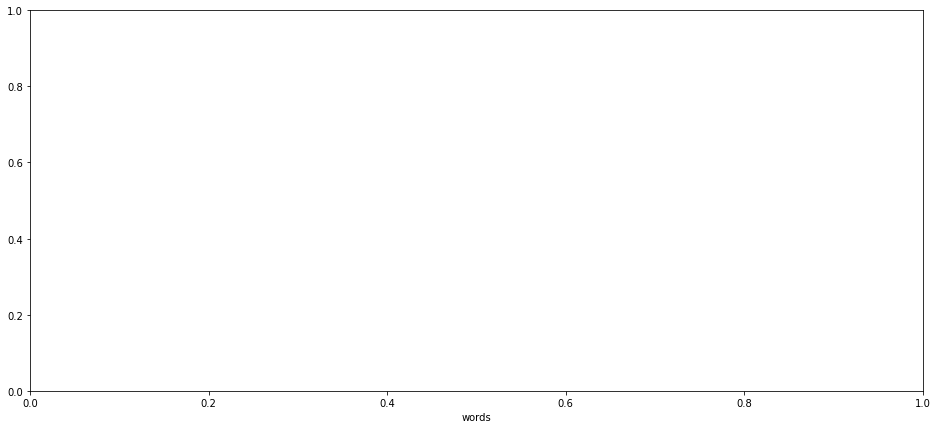

In [ ]:
visual_plot = plt.figure(figsize = (16,7))
visual_plot = plt.gca(xlabel='words')
visual_plot

In [ ]:
# Visible Testing
assert visual_plot.__module__ == 'matplotlib.axes._subplots', "You must create and assign to visual_plot a visualization"


['Natural', 'Language', 'Processing', 'is', 'really', 'fun!']